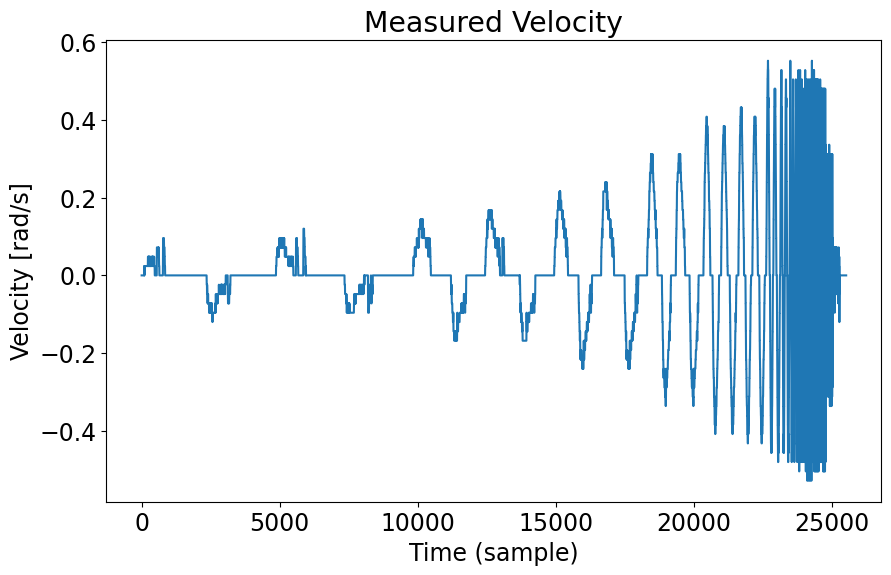

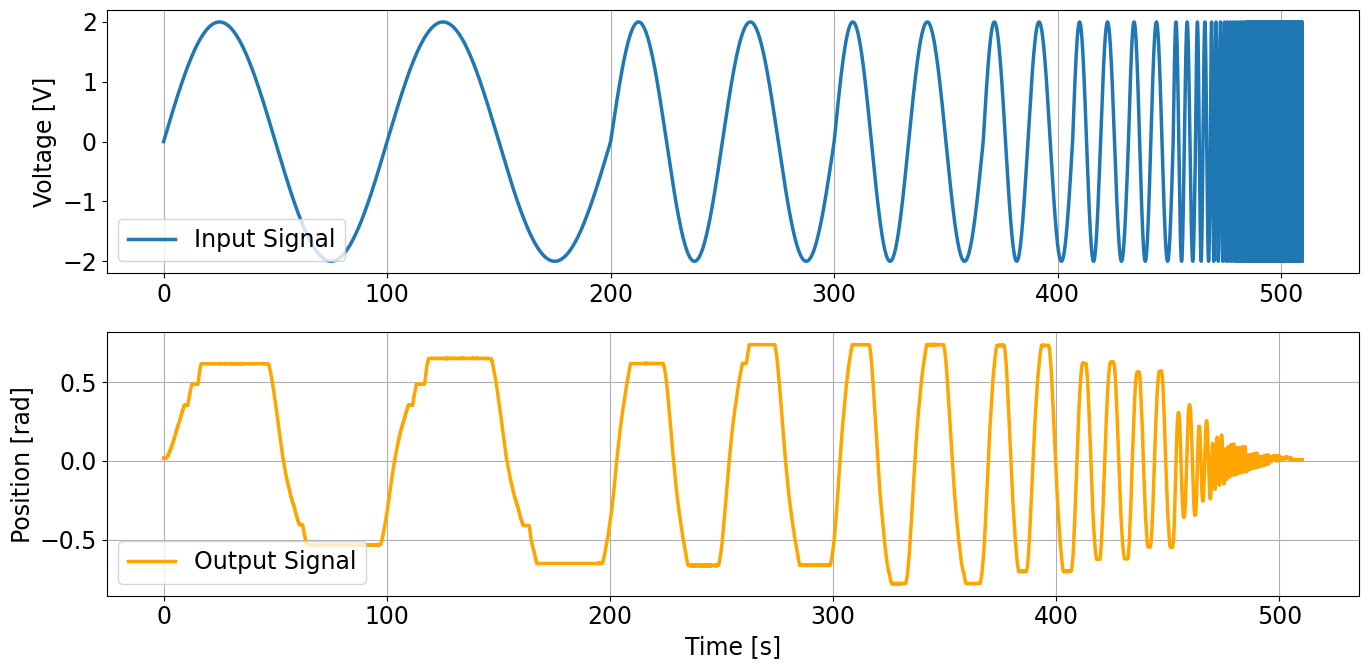

In [26]:
from src.data_processing import process_file
from src.plotting import (
    plot_measured_I, 
    plot_measured_q, 
    plot_measured_q_dot,
    plot_measured_U
)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

# Set the font size globally
mpl.rcParams.update({'font.size': 17})  # Change 14 to your desired font size

# Select the measurements
file_name = "DC_analysis"
file_name = "frequency_analysis"

file_path = f"data/validation_exp/frequency_analysis/{file_name}.txt"

df = process_file(file_path, delta_t=0.02)

df['DXL_Position'] = df['DXL_Position'] - np.pi/2
# df['DXL_Position'] = (df['DXL_Position'] * 180/np.pi - 1.5) * np.pi/180

plot_measured_q_dot(df)


df = df.rename(columns={'t':'time', 'DXL_Position':'position'})
# csv_filename = f'data/validation_exp/chirp_processed/{file_name}.csv'
# df.to_csv(csv_filename, index=False)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initial setup
time_step = 0.005  # Time step in seconds
A = 2  # Amplitude of the sinus waves
# frequencies = [0.001, 0.002, 0.003, 0.005, 0.008, 0.01, 0.02, 0.03, 0.05, 0.08, 1, 2, 3, 5, 8, 25]
frequencies = [0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 0.8, 1, 2, 3, 5, 8, 25]

# Calculate durations for each frequency
durations = []
for f in frequencies:
    period = 1 / f  # Period of the current frequency
    duration_for_2_periods = 2 * period
    duration_for_5_seconds = 5  # Minimum duration of 5 seconds
    # Ensure the duration covers at least two full periods or is at least 5 seconds
    # And adjust to ensure it ends at a zero crossing (full cycle completion)
    duration = max(duration_for_2_periods, duration_for_5_seconds)
    cycles_needed = np.ceil(duration / period)
    adjusted_duration = cycles_needed * period
    durations.append(adjusted_duration)

# Generate the signal
all_times = []
all_amplitudes = []
all_amplitudes_PWM = []
current_time = 0

units = 100/(0.113 * 12)

for f, duration in zip(frequencies, durations):
    segment_time = np.arange(0, duration, time_step)
    segment_amplitude = np.sin(2 * np.pi * f * segment_time) * A
    segment_amplitude_PWM = np.sin(2 * np.pi * f * segment_time) * A * units
    all_times.extend(segment_time + current_time)
    all_amplitudes.extend(segment_amplitude)
    all_amplitudes_PWM.extend(segment_amplitude_PWM)
    current_time += duration

# Create DataFrame
combined_signal = pd.DataFrame({
    'time': all_times,
    'amplitude': all_amplitudes
})

# Time-domain plot
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
# plt.plot(df['time'], df['U'], label='Input Signal')
plt.plot(combined_signal['time'], combined_signal['amplitude'], label='Input Signal', linewidth=2.5)
# plt.title('Time-domain Signal')
plt.ylabel('Voltage [V]')
plt.legend(loc='lower left')
plt.grid(axis="x")
plt.subplot(2, 1, 2)
plt.plot(df['time'], df['position'], label='Output Signal', color='orange', linewidth=2.5)
plt.xlabel('Time [s]')
plt.ylabel('Position [rad]')
plt.legend(loc='lower left')
plt.tight_layout()
plt.grid()
plt.show()


In [5]:
new_df = pd.DataFrame()
new_df['time'] = df['time']
new_df['position'] = df['position']
new_df['U'] = df['U']  

csv_filename = f'freq.csv'
new_df.to_csv(csv_filename, index=False)


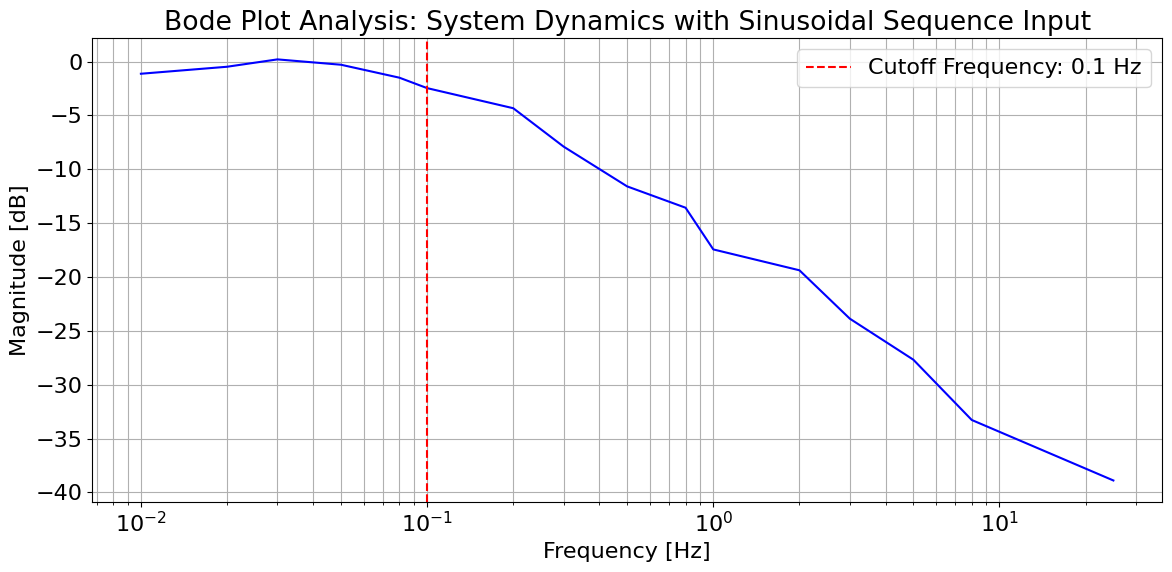

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Constants from the input signal generation
A_input = 3  # Input amplitude
frequencies = [0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 0.8, 1, 2, 3, 5, 8, 25]

# Calculate durations for each frequency
durations = [max(2 / f, 5) for f in frequencies]  # Simplified calculation

# Use the measured DC magnitude for normalization
measured_dc_magnitude = 0.7438  # Base reference magnitude
magnitude = []

for f, duration in zip(frequencies, durations):
    start_time = sum(durations[:frequencies.index(f)])
    end_time = start_time + duration
    segment = output_df[(output_df['time'] >= start_time) & (output_df['time'] < end_time)]
    
    peaks, _ = find_peaks(segment['position'])
    troughs, _ = find_peaks(-segment['position'])
    
    if len(peaks) > 0 and len(troughs) > 0:
        peak_to_peak = segment['position'].iloc[peaks].max() - segment['position'].iloc[troughs].min()
        magnitude.append(20 * np.log10(peak_to_peak / (2 * measured_dc_magnitude)))  # Normalize by 2x amplitude for peak-to-peak
    else:
        magnitude.append(None)

# Determine the cutoff frequency (-3 dB point)
baseline_mag = measured_dc_magnitude #magnitude[0]  # Assuming the first value as baseline
cutoff_mag = baseline_mag - 3
cutoff_freq = next((f for f, mag in zip(frequencies, magnitude) if mag <= cutoff_mag), None)

# Plot Bode magnitude plot
plt.figure(figsize=(12, 6))
plt.semilogx(frequencies, magnitude, 'b-')
plt.title('Bode Plot Analysis: System Dynamics with Sinusoidal Sequence Input')
plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.grid(which='both', axis='both')

if cutoff_freq:
    plt.axvline(x=cutoff_freq, color='r', linestyle='--', label=f'Cutoff Frequency: {cutoff_freq} Hz')
    plt.legend()

plt.tight_layout()
plt.show()


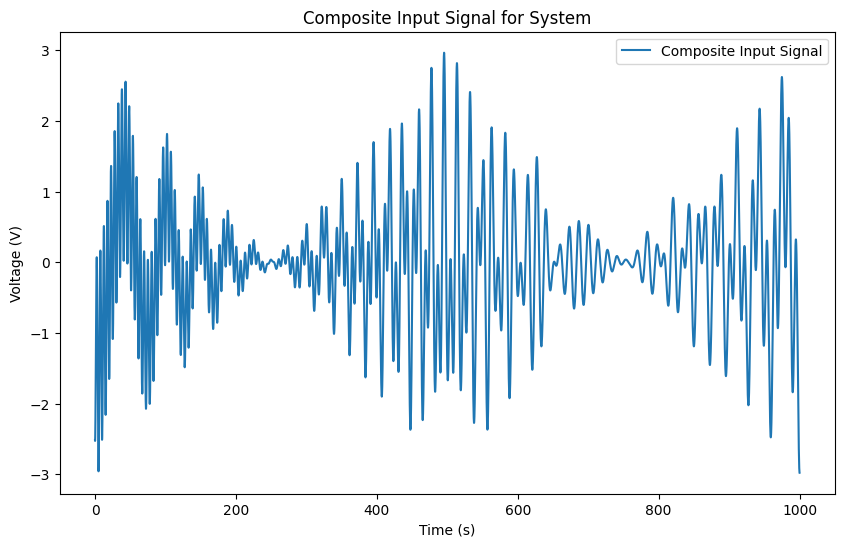

In [80]:
import numpy as np
from scipy.signal import chirp, butter, filtfilt

def generate_low_freq_noise(duration, sampling_rate, cutoff_freq=0.1, order=5):
    """
    Generate low-frequency noise using a Butterworth low-pass filter.
    
    Parameters:
    - duration: Duration of the noise signal in seconds.
    - sampling_rate: Sampling rate in Hz.
    - cutoff_freq: Cutoff frequency of the low-pass filter in Hz.
    - order: Order of the Butterworth filter.
    
    Returns:
    - noise: Low-frequency noise signal.
    """
    # Generate random noise signal
    raw_noise = np.random.uniform(low=-1, high=1, size=int(duration * sampling_rate))
    
    # Normalize the frequency for the digital filter
    norm_cutoff_freq = cutoff_freq / (0.5 * sampling_rate)
    
    # Design Butterworth low-pass filter
    b, a = butter(order, norm_cutoff_freq, btype='low', analog=False)
    
    # Apply filter to the raw noise signal
    noise = filtfilt(b, a, raw_noise)
    
    return noise

def generate_input_signal(duration=10, sampling_rate=200, start_freq=0.01, end_freq=0.1, noise_amplitude=2):
    """
    Generate a composite input signal for the system, including a low-frequency noise component.
    
    Parameters:
    - duration: Duration of the signal in seconds.
    - sampling_rate: Sampling rate in Hz.
    - start_freq: Start frequency of the chirp signal in Hz.
    - end_freq: End frequency of the chirp signal in Hz.
    - noise_amplitude: Amplitude of the low-frequency noise component.
    
    Returns:
    - t: Time array.
    - signal: Generated input signal array.
    """
    # Time array
    t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
    
    # Generate chirp signal
    chirp_signal = chirp(t, f0=start_freq, f1=end_freq, t1=duration, method='linear')
    # chirp_signal2 = chirp(t, f0=end_freq, f1=start_freq, t1=duration, method='linear')
    # chirp_signal3 = chirp(t, f0=start_freq*4, f1=end_freq*4, t1=duration, method='linear')
    chirp_signal4 = chirp(t, f0=end_freq*2, f1=start_freq*2, t1=duration, method='linear')

    
    # Amplitude modulation for chirp signal
    amplitude_modulation = np.linspace(-3, 3, num=len(t)//2)
    amplitude_modulation = np.concatenate([amplitude_modulation, amplitude_modulation[::-1]])
    
    # Ensure amplitude_modulation matches the length of t in case of odd lengths
    if len(amplitude_modulation) != len(t):
        amplitude_modulation = np.append(amplitude_modulation, -12)
    
    # modulated_chirp = (chirp_signal2 + chirp_signal + chirp_signal3 + chirp_signal4) * amplitude_modulation / 2
    modulated_chirp = ( chirp_signal  + chirp_signal4) * amplitude_modulation / 2

    
    # Generate low-frequency noise
    noise = generate_low_freq_noise(duration, sampling_rate) * noise_amplitude
    
    # Composite signal: superimpose modulated chirp and low-frequency noise
    signal = modulated_chirp + noise
    
    # Ensure the signal stays within the [-12, 12] V range
    signal = np.clip(signal, -12, 12)
    
    return t, signal

# Example usage
t, signal = generate_input_signal(duration=1000)  # 60 seconds long signal

# Plot the signal
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Composite Input Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Composite Input Signal for System')
plt.legend()
plt.show()


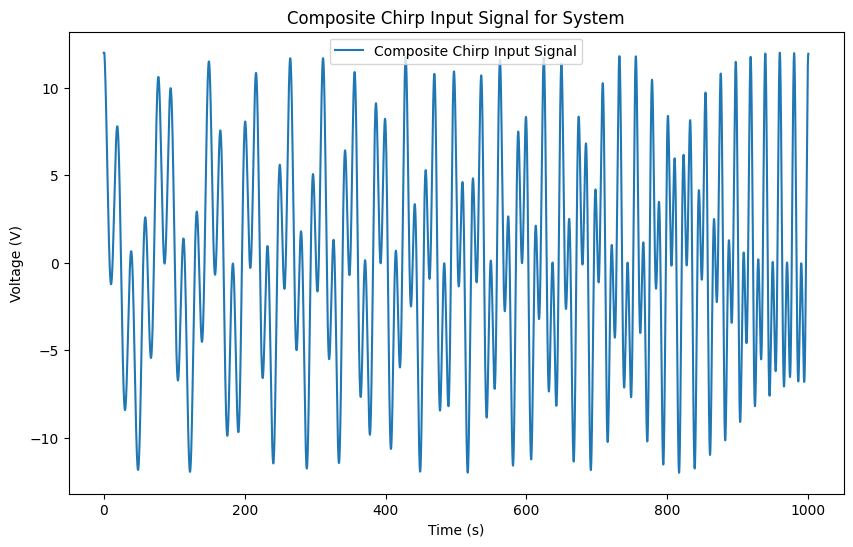

In [83]:
def generate_composite_chirp_signal(duration=10, sampling_rate=200, chirp_configs=None, noise_amplitude=2):
    """
    Generate a composite input signal by summing multiple chirp signals and adding low-frequency noise.

    Parameters:
    - duration: Duration of the signal in seconds.
    - sampling_rate: Sampling rate in Hz.
    - chirp_configs: List of dictionaries, each specifying the start_freq, end_freq, and amplitude for a chirp signal.
    - noise_amplitude: Amplitude of the low-frequency noise component.

    Returns:
    - t: Time array.
    - signal: Generated composite input signal array.
    """
    if chirp_configs is None:
        chirp_configs = [{'start_freq': 0.01, 'end_freq': 0.1, 'amplitude': 12}]

    # Time array
    t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
    signal = np.zeros_like(t)

    for config in chirp_configs:
        # Generate each chirp signal based on its configuration
        chirp_signal = chirp(t, f0=config['start_freq'], f1=config['end_freq'], t1=duration, method='linear')
        # Apply amplitude
        chirp_signal *= config['amplitude']
        # Summing up the chirps
        signal += chirp_signal

    # Add low-frequency noise
    noise = generate_low_freq_noise(duration, sampling_rate) * noise_amplitude
    signal += noise

    # Ensure the signal stays within the [-12, 12] V range
    signal = np.clip(signal, -12, 12)
    
    return t, signal

# Example usage
chirp_configs = [
    {'start_freq': 0.01, 'end_freq': 0.05, 'amplitude': 6},
    {'start_freq': 0.05, 'end_freq': 0.1, 'amplitude': 6},
    # Add more configurations as needed
]
t, signal = generate_composite_chirp_signal(duration=1000, chirp_configs=chirp_configs)

# Plot the signal
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Composite Chirp Input Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Composite Chirp Input Signal for System')
plt.legend()
plt.show()


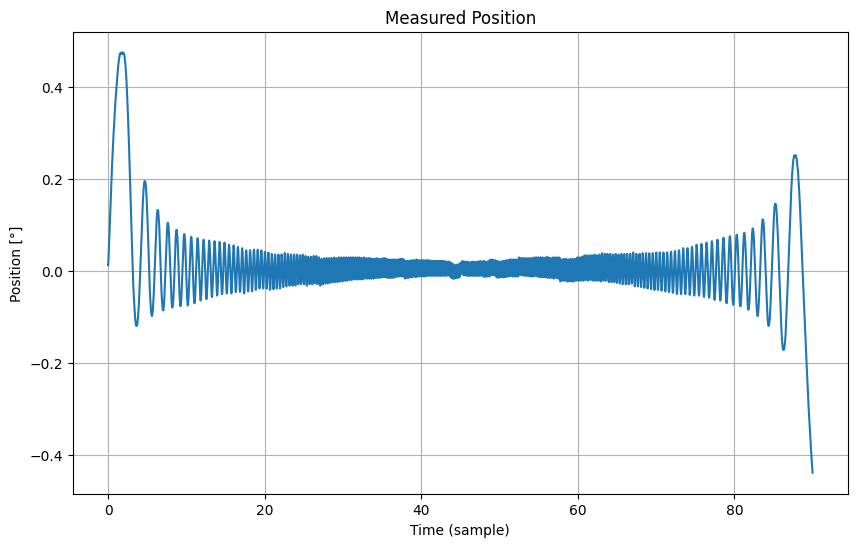

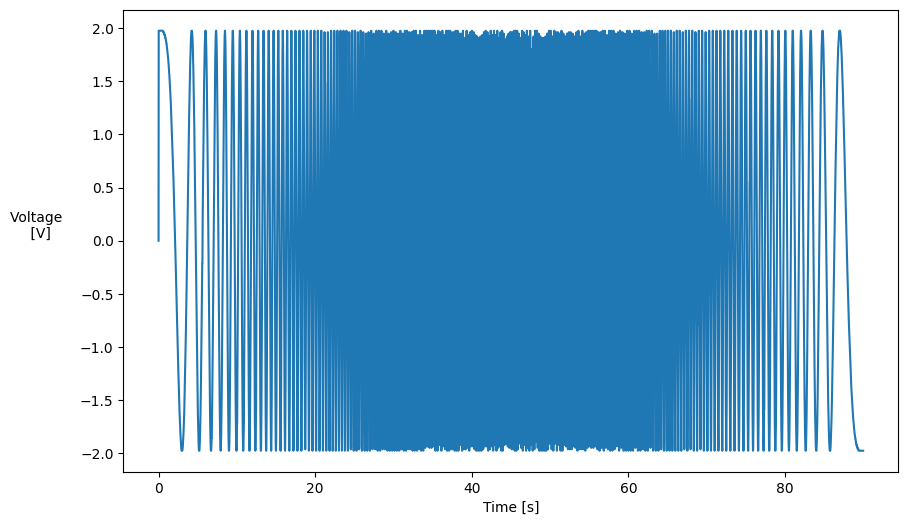

In [20]:
from src.data_processing import process_file
from src.plotting import (
    plot_measured_I, 
    plot_measured_q, 
    plot_measured_q_dot,
    plot_measured_U
)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Select the measurements
file_name = "chirp_1"
# file_name = "non_trivial_2"

file_path = f"data/validation_exp/calibration/{file_name}.txt"

df = process_file(file_path, delta_t=0.02)

df['DXL_Position'] = df['DXL_Position'] - np.pi/2
df['DXL_Position'] = (df['DXL_Position'] * 180/np.pi - 1.6) * np.pi/180

plot_measured_q(df)
plot_measured_U(df)

df = df.rename(columns={'t':'timestamp', 'DXL_Position':'θ(t)'})
csv_filename = f'data/validation_exp/calibration_processed/{file_name}.csv'
# df.to_csv(csv_filename, index=False)

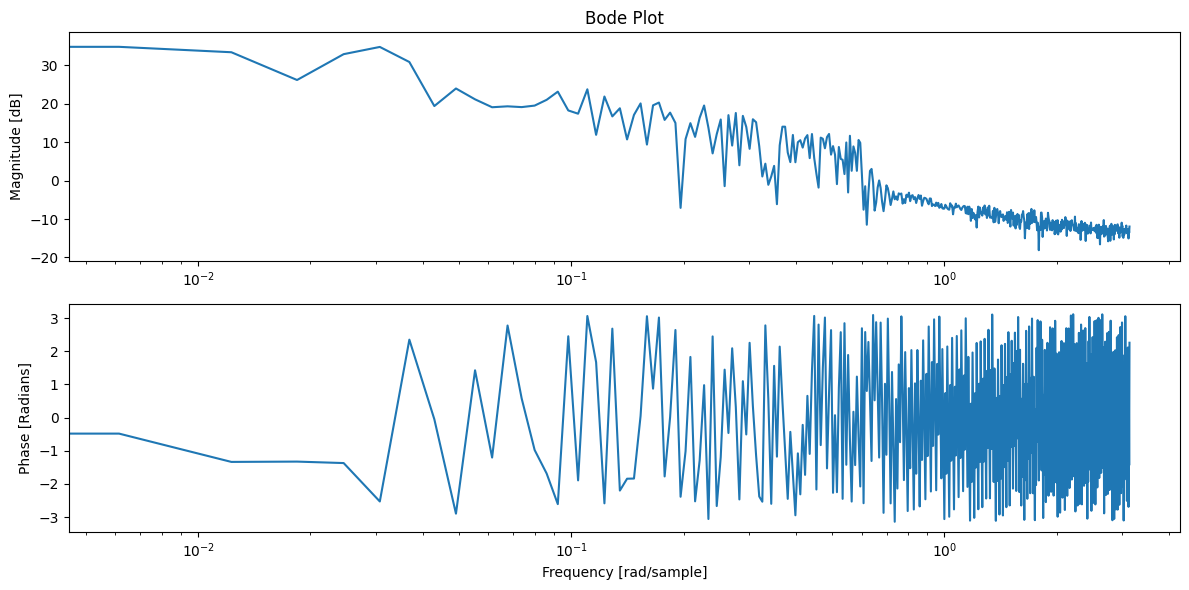

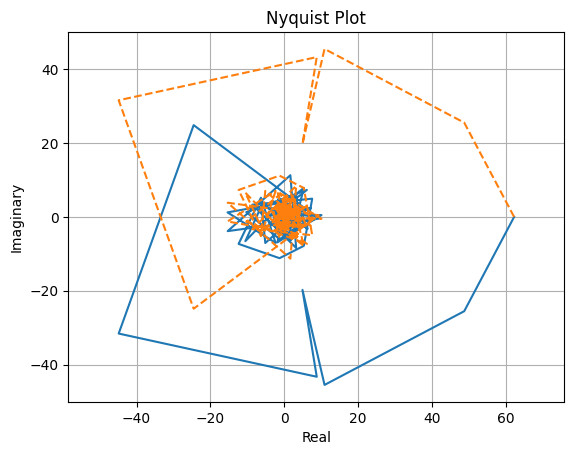

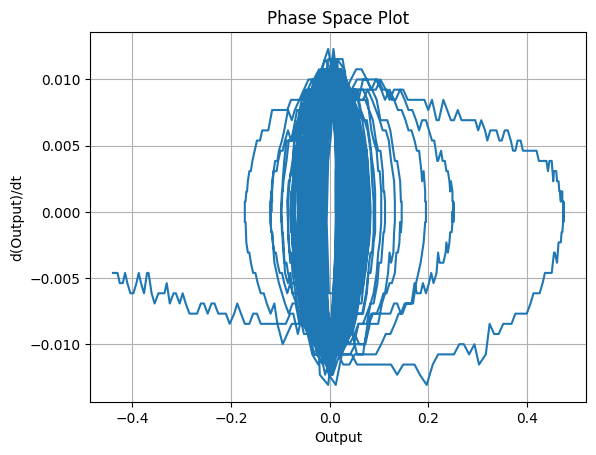

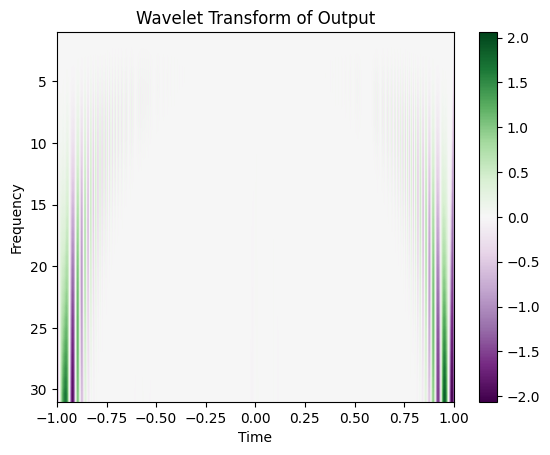

In [24]:
from scipy.signal import freqz

# Bode plot
w, h = freqz(df['θ(t)'])
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Bode Plot')
plt.ylabel('Magnitude [dB]')
plt.subplot(2, 1, 2)
plt.semilogx(w, np.angle(h))
plt.xlabel('Frequency [rad/sample]')
plt.ylabel('Phase [Radians]')
plt.tight_layout()
plt.show()

# Nyquist plot
plt.figure()
plt.plot(np.real(h), np.imag(h))
plt.plot(np.real(h), -np.imag(h), '--')
plt.title('Nyquist Plot')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid(True)
plt.axis('equal')
plt.show()

# Phase space plot
plt.figure()
plt.plot(df['θ(t)'], np.gradient(df['θ(t)']))
plt.title('Phase Space Plot')
plt.xlabel('Output')
plt.ylabel('d(Output)/dt')
plt.grid(True)
plt.show()

# Wavelet Transform - We'll use a simple example with a continuous wavelet transform (CWT)
from scipy.signal import cwt, ricker
widths = np.arange(1, 31)
cwtmatr = cwt(df['θ(t)'], ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 31, 1], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.title('Wavelet Transform of Output')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

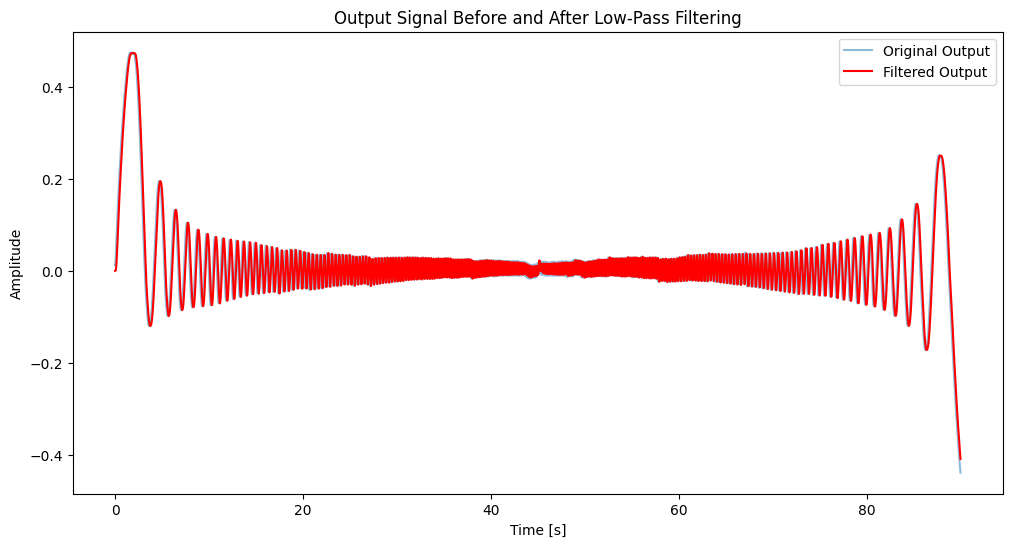

In [22]:
import numpy as np
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

# Function to design a Butterworth low-pass filter and apply it
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data

# Your data
# Assuming 'df' is your DataFrame and 'θ(t)' is your output column
output_data = df['θ(t)'].values

# Filter specifications
cutoff_frequency = 5  # Cutoff frequency in Hz, adjust based on your needs
sampling_frequency = 50  # Sampling frequency in Hz (1 / timestep)
order = 6  # Filter order, adjust based on your needs

# Apply the filter
filtered_output = butter_lowpass_filter(output_data, cutoff_frequency, sampling_frequency, order)

# Plot the original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], output_data, label='Original Output', alpha=0.5)
plt.plot(df['timestamp'], filtered_output, label='Filtered Output', color='red')
plt.title('Output Signal Before and After Low-Pass Filtering')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

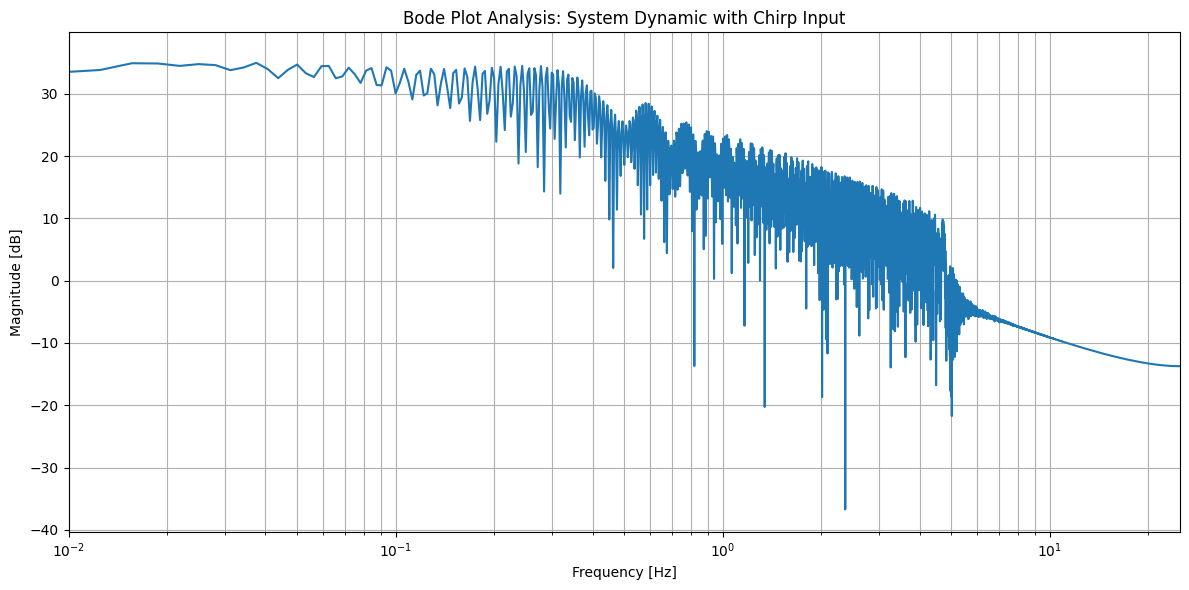

In [23]:
from scipy.signal import freqz
import matplotlib.pyplot as plt
import numpy as np

# Sampling period and frequency
Ts = 0.02  # Sampling period in seconds
fs = 1 / Ts  # Sampling frequency in Hz

# Generate frequency response
w, h = freqz(filtered_output, worN=8000)  # Increase worN for finer resolution if needed
f = w * (fs / (2 * np.pi))  # Convert from rad/sample to Hz

# Plot Bode magnitude plot
plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
plt.semilogx(f, 20 * np.log10(abs(h)))  # Magnitude in dB
plt.title('Bode Plot Analysis: System Dynamic with Chirp Input')
plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.xlim([10e-3, fs/2])  # Limit x-axis to Nyquist frequency
plt.grid(which='both', axis='both')

# It is clearly a low-pass filter, with 30dB par decade. 
plt.tight_layout()
plt.show()

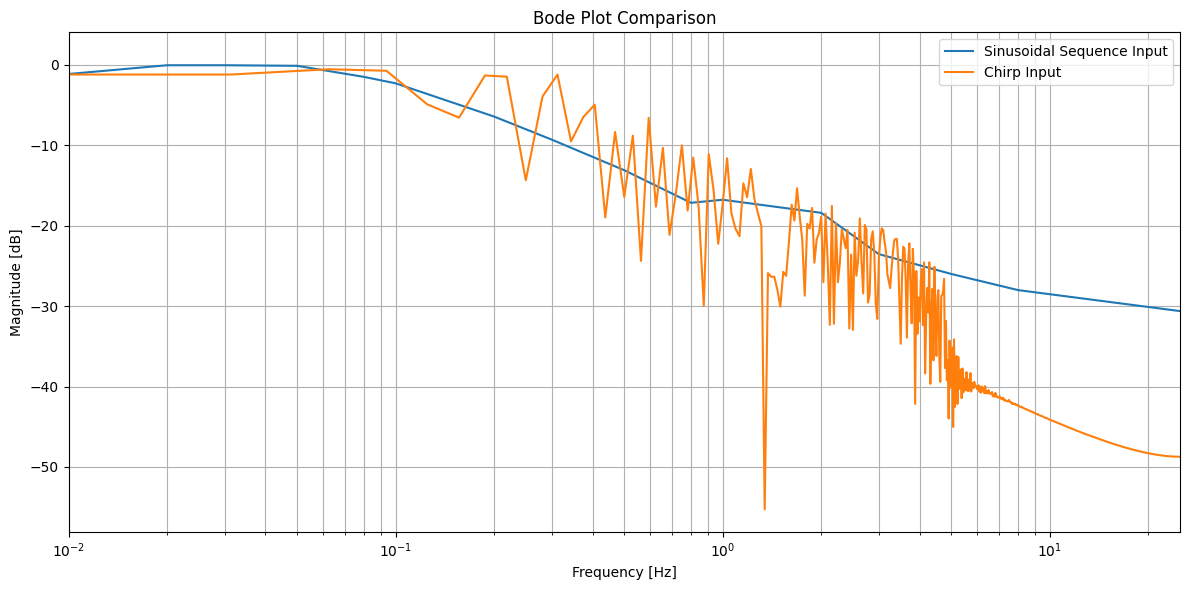

In [48]:
from scipy.signal import freqz
import matplotlib.pyplot as plt
import numpy as np

magnitude_sin = magnitude  # Your calculated magnitude list from the sinusoidal sequence experiment
frequencies_sin = frequencies  # Your frequency array from the sinusoidal sequence experiment

# Chirp signal experiment's Bode plot data
Ts = 0.02  # Sampling period in seconds for chirp signal experiment
fs_chirp = 1 / Ts  # Sampling frequency in Hz
w, h = freqz(filtered_output, worN=800)
f_chirp = w * (fs_chirp / (2 * np.pi))  # Convert from rad/sample to Hz for chirp signal experiment
measured_dc_magnitude_db = 20 * np.log10(measured_dc_magnitude)  # Convert DC value to dB

# Plot both Bode magnitude plots for comparison
plt.figure(figsize=(12, 6))
plt.semilogx(frequencies_sin, magnitude_sin, label='Sinusoidal Sequence Input')  # Sinusoidal sequence
plt.semilogx(f_chirp, 20 * np.log10(abs(h)) - 35, label='Chirp Input')  # Chirp signal
plt.title('Bode Plot Comparison')
plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.xlim([10e-3, max(fs_chirp/2, max(frequencies_sin))])  # Adjust x-axis limit as needed
plt.grid(which='both', axis='both')
plt.legend()

plt.tight_layout()
plt.show()
